In [4]:
import glob
import numpy as np
import scipy.io
from tqdm import tqdm
import h5py
import re
import copy

# function to expand the input matrix based on expd_size
def expd(original_mat, expd_size):
    sz_diff = np.floor((expd_size-original_mat.shape[0])/2).astype(int)
    output = np.zeros([expd_size,expd_size])
    output[sz_diff:sz_diff+original_mat.shape[0], sz_diff:sz_diff+original_mat.shape[1]] = original_mat
    return output

# check and create output folder
import os
outputFolder = './data'
try:
    os.makedirs(outputFolder)
except:
    pass

# get all cases folder name
cases = glob.glob('../Matlab_simulation_data/case1*')
cases.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

save_freq = 10 # 0 for per10, 00 for per 100
len_iter = int(35000/save_freq)
ignore_Iter = int(500/save_freq)
expd_size = 400 # target domain size
dwn = 4 # down sample ratio
dwn_sz = int(expd_size/dwn)
numCases = len(cases)

hdf5_file = h5py.File(outputFolder+'/All_cases_'+str(int(dwn_sz))+'x'+str(int(dwn_sz))+'_tips.hdf5', mode='w')
hdf5_file.create_dataset("phi", (numCases*(len_iter-ignore_Iter-1), dwn_sz, dwn_sz, 2), np.float64, chunks=(1, dwn_sz, dwn_sz, 1), compression="gzip")

phi_dwn = []
tips_dwn = []
jj = 0
for i in tqdm (range(len(cases)), desc="Running ..."):
    inputFolder = cases[i]
    case = inputFolder.replace('../Matlab_simulation_data','')

    # load and expand theta
    thetaPath = glob.glob(inputFolder+'/theta_35000.mat')
    theta_temp = np.array(scipy.io.loadmat(thetaPath[0])['theta_plot'].todense())
    thetaExpd = expd(theta_temp, expd_size)
    # theta_dwn = thetaExpd[0::2,0::2]
    theta_dwn = thetaExpd[0::2,0::2]

    # defined input data folder and grab a list of data files
    phiPath = glob.glob(inputFolder+'/phi*0.mat') # 0 to sample data per 10 data points
    phiPath.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

    # load and expand theta
    tipsPath = glob.glob(inputFolder+'/tips*0.mat')
    tipsPath.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

    for j in range(len(phiPath)):
        if j > ignore_Iter:
            s = phiPath[j]
            iter = int(s.replace('../Matlab_simulation_data'+case+'/phi_','').replace('.mat',''))
            # print(iter)
            if ((iter % save_freq) == 0):
            # if ((iter % save_freq) == 0) and (iter > 500):

                # load data
                phi_temp = scipy.io.loadmat(s)['phi_plot']
                phi_temp = np.round(expd(phi_temp, expd_size))
                
                phi_dwn = phi_temp[0::2,0::2]
                hdf5_file["phi"][jj, :, :, 0] = phi_dwn[50:150,50:150]

                tips_temp = np.array(scipy.io.loadmat(tipsPath[j])['theta_ori'])
                tips_temp = np.round(expd(tips_temp, expd_size))
                tips_dwn = tips_temp[0::2,0::2]

                hdf5_file["phi"][jj, :, :, 1] = tips_dwn[50:150,50:150]

                jj+=1

hdf5_file.close()

Running ...: 100%|██████████| 12/12 [01:47<00:00,  8.92s/it]


In [3]:
len_iter

350

In [4]:
numCases

92

In [5]:
import h5py
h5 = h5py.File('./data/All_cases_100x100_tips.hdf5', mode='r')
ind = h5.get('phi')
ind.shape

(41388, 100, 100, 2)

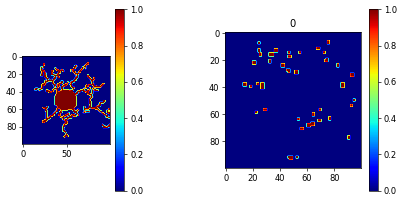

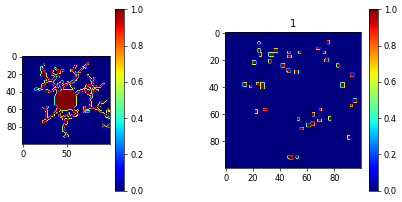

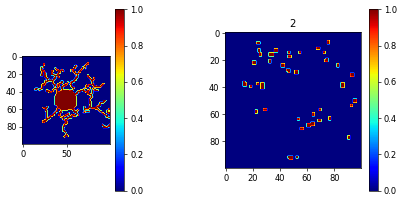

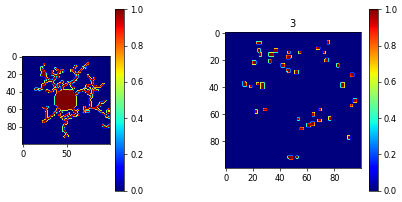

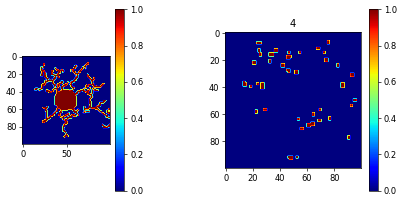

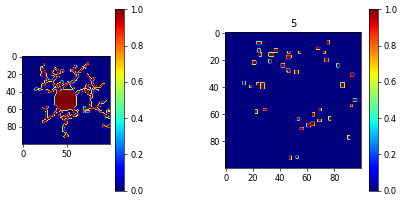

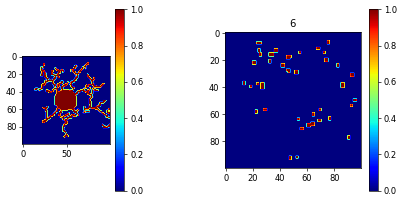

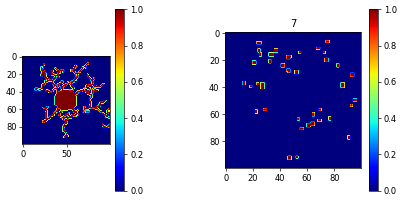

IndexError: Index (41388) out of range for (0-41387)

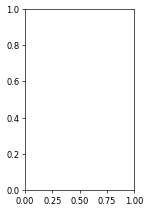

In [6]:
import matplotlib.pyplot as plt
numFrames=ind.shape[1]
numFrames = 20
for i in range(numFrames):
    plt.figure(figsize=(8, 4), dpi=60)
    plt.subplot(1,3,1)
    plt.imshow(ind[i+41380,:,:,0],cmap='jet')
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(ind[i+41380,:,:,1],cmap='jet')
    plt.colorbar()
    plt.title(i)
    plt.show()
h5.close()